# Training a Custom TensorFlow.js Audio Model

In this notebook, we show how to train a custom audio model based on the model topology of the
[TensorFlow.js Speech Commands model](https://www.npmjs.com/package/@tensorflow-models/speech-commands).
The training is done in Python by using a set of audio examples stored as .wav files.
The trained model is convertible to the
[TensorFlow.js LayersModel](https://js.tensorflow.org/api/latest/#loadLayersModel) format for
inference and further fine-tuning in the browser.
It may also be converted to the [TFLite](https://www.tensorflow.org/lite) format
for inference on mobile devices.

This example uses a small subset of the
[Speech Commands v0.02](https://arxiv.org/abs/1804.03209) dataset, and builds
a model that detects two English words ("yes" and "no") against background noises. But the methodology demonstrated here is general and can be applied to
other sounds, as long as they are stored in the same .wav file format as in this example.

## Data format

The training procedure in this notebook makes the following assumption about the raw audio data:

1. The root data directory contains a number of folders. The name of each folder is the name
   of the audio class. You can select any subset of the folders (i.e., classes) to train the
   model on.
2. Within each folder, there are a number of .wav files. Each .wav file corresponds to an
   example. Each .wav file is mono (single-channel) and has the typical pulse-code modulation
   (PCM) encoding. The duration of each wave file should be 1 second or slightly longer. 
3. There can be a special folder called "_background_noise_" that contains .wav files for
   audio samples that fall into the background noise class. Each of these .wav files can be
   much longer than 1 second in duration. This notebook contains code that extracts 1-second
   snippets from these .wav files
   
The Speech Commands v0.3 dataset used in this notebook meets these data format requirements.

In [4]:
!pip install librosa tensorflowjs

In [5]:
import glob
import json
import os
import random

import librosa
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import wavfile
import tensorflow as tf
import tensorflowjs as tfjs
import tqdm

print(tf.__version__)
print(tfjs.__version__)

2.5.0
1.7.0


In [6]:
pip install tflite-model-maker

In [7]:
# Download the TensorFlow.js Speech Commands model and the associated
# preprocesssing model.
!mkdir -p /tmp/tfjs-sc-model
!curl -o /tmp/tfjs-sc-model/metadata.json -fsSL https://storage.googleapis.com/tfjs-models/tfjs/speech-commands/v0.3/browser_fft/18w/metadata.json
!curl -o /tmp/tfjs-sc-model/model.json -fsSL https://storage.googleapis.com/tfjs-models/tfjs/speech-commands/v0.3/browser_fft/18w/model.json
!curl -o /tmp/tfjs-sc-model/group1-shard1of2 -fSsL https://storage.googleapis.com/tfjs-models/tfjs/speech-commands/v0.3/browser_fft/18w/group1-shard1of2
!curl -o /tmp/tfjs-sc-model/group1-shard2of2 -fsSL https://storage.googleapis.com/tfjs-models/tfjs/speech-commands/v0.3/browser_fft/18w/group1-shard2of2
!curl -o /tmp/tfjs-sc-model/sc_preproc_model.tar.gz -fSsL https://storage.googleapis.com/tfjs-models/tfjs/speech-commands/conversion/sc_preproc_model.tar.gz
!cd /tmp/tfjs-sc-model/ && tar xzvf sc_preproc_model.tar.gz

sc_preproc_model/
sc_preproc_model/assets/
sc_preproc_model/variables/
sc_preproc_model/variables/variables.data-00000-of-00001
sc_preproc_model/variables/variables.index
sc_preproc_model/saved_model.pb


In [8]:
# Download Speech Commands v0.02 dataset. The dataset contains 30+ word and
# sound categories, but we will only use a subset of them

!mkdir -p /tmp/speech_commands_v0.02
!curl -o /tmp/speech_commands_v0.02/speech_commands_v0.02.tar.gz -fSsL http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz
!cd  /tmp/speech_commands_v0.02 && tar xzf speech_commands_v0.02.tar.gz

In [9]:
# Load the preprocessing model, which transforms audio waveform into 
# spectrograms (2D image-like representation of sound).
# This preprocessing model replicates WebAudio's AnalyzerNode.getFloatFrequencyData
# (https://developer.mozilla.org/en-US/docs/Web/API/AnalyserNode/getFloatFrequencyData).
# It performs short-time Fourier transform (STFT) using a length-2048 Blackman
# window. It opeartes on mono audio at the 44100-Hz sample rate.

preproc_model_path = '/tmp/tfjs-sc-model/sc_preproc_model'
preproc_model = tf.keras.models.load_model(preproc_model_path)
preproc_model.summary()
preproc_model.input_shape

Model: "audio_preproc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
audio_preprocessing_layer (A (None, None, 232, 1)      2048      
Total params: 2,048
Trainable params: 0
Non-trainable params: 2,048
_________________________________________________________________


(None, 44032)

In [10]:
# Create some constants to be used later.

# Target sampling rate. It is required by the audio preprocessing model.
TARGET_SAMPLE_RATE = 44100
# The specific audio tensor length expected by the preprocessing model.
EXPECTED_WAVEFORM_LEN = preproc_model.input_shape[-1]

# Where the Speech Commands v0.02 dataset has been downloaded.
DATA_ROOT = "/tmp/speech_commands_v0.02"

WORDS = ("_background_noise_snippets_", "four", "stop", "up")

In [11]:
# Unlike word examples, the noise samples in the Speech Commands v0.02 dataset
# are not divided into 1-second snippets. Instead, they are stored as longer
# recordings. Therefore we need to cut them up in to 1-second snippet .wav
# files.

noise_wav_paths = glob.glob(os.path.join(DATA_ROOT, "_background_noise_", "*.wav"))
snippets_dir = os.path.join(DATA_ROOT, "_background_noise_snippets_")
os.makedirs(snippets_dir, exist_ok=True)


def extract_snippets(wav_path, snippet_duration_sec=1.0):
  basename = os.path.basename(os.path.splitext(wav_path)[0])
  sample_rate, xs = wavfile.read(wav_path)
  assert xs.dtype == np.int16
  n_samples_per_snippet = int(snippet_duration_sec * sample_rate)
  i = 0
  while i + n_samples_per_snippet < len(xs):
    snippet_wav_path = os.path.join(snippets_dir, "%s_%.5d.wav" % (basename, i))
    snippet = xs[i : i + n_samples_per_snippet].astype(np.int16)
    wavfile.write(snippet_wav_path, sample_rate, snippet)
    i += n_samples_per_snippet

for noise_wav_path in noise_wav_paths:
  print("Extracting snippets from %s..." % noise_wav_path)
  extract_snippets(noise_wav_path, snippet_duration_sec=1.0)

Extracting snippets from /tmp/speech_commands_v0.02/_background_noise_/doing_the_dishes.wav...
Extracting snippets from /tmp/speech_commands_v0.02/_background_noise_/exercise_bike.wav...
Extracting snippets from /tmp/speech_commands_v0.02/_background_noise_/pink_noise.wav...
Extracting snippets from /tmp/speech_commands_v0.02/_background_noise_/dude_miaowing.wav...
Extracting snippets from /tmp/speech_commands_v0.02/_background_noise_/running_tap.wav...
Extracting snippets from /tmp/speech_commands_v0.02/_background_noise_/white_noise.wav...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: WavFileWarning: Chunk (non-data) not understood, skipping it.
  del sys.path[0]


In [12]:
def resample_wavs(dir_path, target_sample_rate=44100):
  """Resample the .wav files in an input directory to given sampling rate.
  
  The resampled waveforms are written to .wav files in the same directory with
  file names that ends in "_44100hz.wav".

  44100 Hz is the sample rate required by the preprocessing model. It is also
  the most widely supported sample rate among web browsers and mobile devices.
  For example, see:
  https://developer.mozilla.org/en-US/docs/Web/API/AudioContextOptions/sampleRate
  https://developer.android.com/ndk/guides/audio/sampling-audio

  Args:
    dir_path: Path to a directory that contains .wav files.
    target_sapmle_rate: Target sampling rate in Hz.
  """
  wav_paths = glob.glob(os.path.join(dir_path, "*.wav"))
  resampled_suffix = "_%shz.wav" % target_sample_rate
  for i, wav_path in tqdm.tqdm(enumerate(wav_paths)):
    if wav_path.endswith(resampled_suffix):
      continue
    sample_rate, xs = wavfile.read(wav_path)
    xs = xs.astype(np.float32)
    xs = librosa.resample(xs, sample_rate, TARGET_SAMPLE_RATE).astype(np.int16)
    resampled_path = os.path.splitext(wav_path)[0] + resampled_suffix
    wavfile.write(resampled_path, target_sample_rate, xs)


for word in WORDS:
  word_dir = os.path.join(DATA_ROOT, word)
  assert os.path.isdir(word_dir)
  resample_wavs(word_dir, target_sample_rate=TARGET_SAMPLE_RATE)

396it [00:19, 20.31it/s]
3728it [02:55, 21.28it/s]
3872it [03:00, 21.41it/s]
3723it [02:52, 21.60it/s]


In [13]:
@tf.function
def read_wav(filepath):
  file_contents = tf.io.read_file(filepath)
  return tf.expand_dims(tf.squeeze(tf.audio.decode_wav(
      file_contents, 
      desired_channels=-1,
      desired_samples=TARGET_SAMPLE_RATE).audio, axis=-1), 0)


@tf.function
def filter_by_waveform_length(waveform, label):
  return tf.size(waveform) > EXPECTED_WAVEFORM_LEN


@tf.function
def crop_and_convert_to_spectrogram(waveform, label):
  cropped = tf.slice(waveform, begin=[0, 0], size=[1, EXPECTED_WAVEFORM_LEN])
  return tf.squeeze(preproc_model(cropped), axis=0), label


@tf.function
def spectrogram_elements_finite(spectrogram, label):
  return tf.math.reduce_all(tf.math.is_finite(spectrogram))


def get_dataset(input_wav_paths, labels):
  """Get a tf.data.Dataset given input .wav files and their labels.

  The returned dataset emits 2-tuples of `(spectrogram, label)`, wherein
  - `spectrogram` is a tensor of dtype tf.float32 and shape [43, 232, 1].
    It is z-normalized (i.e., have a mean of ~0.0 and variance of ~1.0).
  - `label` is a tensor of dtype tf.int32 and shape [] (scalar).
  
  Args:
    input_wav_paths: Input audio .wav file paths as a list of string.
    labels: integer labels (class indices) of the input .wav files. Must have
      the same lengh as `input_wav_paths`.

  Returns:
    A tf.data.Dataset object as described above.
  """
  ds = tf.data.Dataset.from_tensor_slices(input_wav_paths)
  # Read audio waveform from the .wav files.
  ds = ds.map(read_wav)
  ds = tf.data.Dataset.zip((ds, tf.data.Dataset.from_tensor_slices(labels)))
  # Keep only the waveforms longer than `EXPECTED_WAVEFORM_LEN`.
  ds = ds.filter(filter_by_waveform_length)
  # Crop the waveforms to `EXPECTED_WAVEFORM_LEN` and convert them to
  # spectrograms using the preprocessing layer.
  ds = ds.map(crop_and_convert_to_spectrogram)
  # Discard examples that contain infinite or NaN elements.
  ds = ds.filter(spectrogram_elements_finite)
  return ds

Found 396 examples for class _background_noise_snippets_
Found 3728 examples for class four
Found 3872 examples for class stop
Found 3723 examples for class up


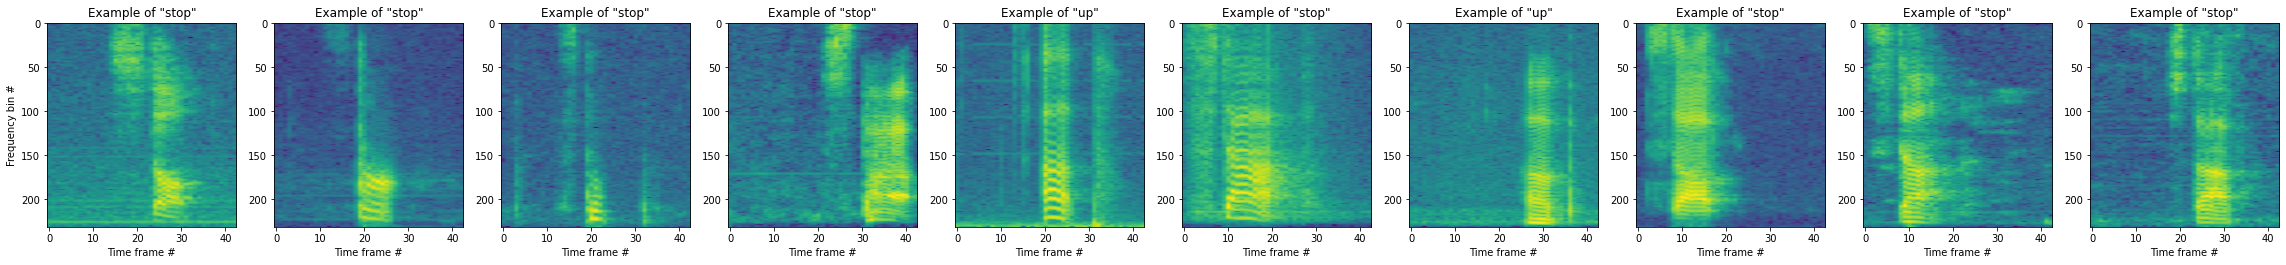

In [14]:
input_wav_paths_and_labels = []
for i, word in enumerate(WORDS):
  wav_paths = glob.glob(os.path.join(DATA_ROOT, word, "*_%shz.wav" % TARGET_SAMPLE_RATE))
  print("Found %d examples for class %s" % (len(wav_paths), word))
  labels = [i] * len(wav_paths)
  input_wav_paths_and_labels.extend(zip(wav_paths, labels))
random.shuffle(input_wav_paths_and_labels)
  
input_wav_paths, labels = ([t[0] for t in input_wav_paths_and_labels],
                           [t[1] for t in input_wav_paths_and_labels])
dataset = get_dataset(input_wav_paths, labels)

# Show some example spectrograms for inspection.
fig = plt.figure(figsize=(40, 100))
dataset_iter = iter(dataset)
num_spectrograms_to_show = 10
for i in range(num_spectrograms_to_show):
  ax = fig.add_subplot(1, num_spectrograms_to_show, i + 1)
  spectrogram, label = next(dataset_iter)
  spectrogram = spectrogram.numpy()
  label = label.numpy()
  plt.imshow(np.flipud(np.squeeze(spectrogram, -1).T), aspect=0.2)
  ax.set_title("Example of \"%s\"" % WORDS[label])
  ax.set_xlabel("Time frame #")
  if i == 0:
    ax.set_ylabel("Frequency bin #")

In [15]:
# The amount of data we have is relatively small. It fits into typical host RAM
# or GPU memory. For better training performance, we preload the data and
# put it into numpy arrays:
# - xs: The audio features (normalized spectrograms).
# - ys: The labels (class indices).
print(
    "Loading dataset and converting data to numpy arrays. "
    "This may take a few minutes...")
xs_and_ys = list(dataset)
xs = np.stack([item[0] for item in xs_and_ys])
ys = np.stack([item[1] for item in xs_and_ys])
print("Done.")

Loading dataset and converting data to numpy arrays. This may take a few minutes...
Done.


In [16]:
tfjs_model_json_path = '/tmp/tfjs-sc-model/model.json'

# Load the Speech Commands model. Weights are loaded along with the topology,
# since we train the model from scratch. Instead, we will perform transfer
# learning based on the model.
orig_model = tfjs.converters.load_keras_model(tfjs_model_json_path, load_weights=True)

# Remove the top Dense layer and add a new Dense layer of which the output
# size fits the number of sound classes we care about.
model = tf.keras.Sequential(name="TransferLearnedModel")
for layer in orig_model.layers[:-1]:
  model.add(layer)
model.add(tf.keras.layers.Dense(units=len(WORDS), activation="softmax"))

# Freeze all but the last layer of the model. The last layer will be fine-tuned
# during transfer learning.
for layer in model.layers[:-1]:
  layer.trainable = False

model.compile(optimizer="sgd", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.summary()

Model: "TransferLearnedModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 42, 225, 8)        136       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 112, 8)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 109, 32)       2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 54, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 51, 32)         8224      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 25, 32)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 22, 32)

In [17]:
# Train the model.
model.fit(xs, ys, batch_size=256, validation_split=0.3, shuffle=True, epochs=50)

Epoch 1/50
29/29 [==============================] - 15s 500ms/step - loss: 0.6603 - acc: 0.7922 - val_loss: 0.1632 - val_acc: 0.9446
Epoch 2/50
29/29 [==============================] - 14s 477ms/step - loss: 0.2683 - acc: 0.9071 - val_loss: 0.1271 - val_acc: 0.9535
Epoch 3/50
29/29 [==============================] - 14s 472ms/step - loss: 0.2210 - acc: 0.9243 - val_loss: 0.1124 - val_acc: 0.9599
Epoch 4/50
29/29 [==============================] - 14s 473ms/step - loss: 0.1934 - acc: 0.9365 - val_loss: 0.1045 - val_acc: 0.9634
Epoch 5/50
29/29 [==============================] - 14s 471ms/step - loss: 0.1865 - acc: 0.9397 - val_loss: 0.0991 - val_acc: 0.9660
Epoch 6/50
29/29 [==============================] - 14s 472ms/step - loss: 0.1671 - acc: 0.9446 - val_loss: 0.0956 - val_acc: 0.9675
Epoch 7/50
29/29 [==============================] - 14s 470ms/step - loss: 0.1652 - acc: 0.9475 - val_loss: 0.0916 - val_acc: 0.9688
Epoch 8/50
29/29 [==============================] - 14s 473ms/step - 

In [18]:
!pip install config

In [19]:
tfjs_model_dir = "/tmp/tfjs-model"
tfjs.converters.save_keras_model(model, tfjs_model_dir)

In [21]:
# Convert the model to TensorFlow.js Layers model format.

# Create the metadata.json file.
metadata = {"words": ["_background_noise_"] + ["four"] + ["stop"] + ["up"], "frameSize": model.input_shape[-2]}
with open(os.path.join(tfjs_model_dir, "metadata.json"), "w") as f:
  json.dump(metadata, f)

!ls -lh /tmp/tfjs-model

total 5.5M
-rw-r--r-- 1 root root 4.0M Jun  2 07:14 group1-shard1of2.bin
-rw-r--r-- 1 root root 1.5M Jun  2 07:14 group1-shard2of2.bin
-rw-r--r-- 1 root root   73 Jun  2 07:15 metadata.json
-rw-r--r-- 1 root root 6.3K Jun  2 07:14 model.json


To deploy this model to the web, you can use the
[speech-commands NPM package](https://www.npmjs.com/package/@tensorflow-models/speech-commands).

The model.json and metadata.json should be hosted together with the two weights (.bin) files in the same HTTP/HTTPS directory.

Then the custom model can be loaded in JavaScript with:

```js
import * as tf from '@tensorflow/tfjs-core';
import * as tfl from '@tensorflow/tfjs-layers';
import * as speechCommands from '@tensorflow-models/speech-commands';

const recognizer = speechCommands.create(
    'BROWSER_FFT',
    null,
    'http://test.com/my-audio-model/model.json',  // URL to the custom model's model.json
    'http://test.com/my-audio-model/metadata.json'  // URL to the custom model's metadata.json
);
```

In [22]:
# Convert the model to TFLite. 

# We need to combine the preprocessing model and the newly trained 3-class model
# so that the resultant model will be able to preform STFT and spectrogram 
# calculation on mobile devices (i.e., without web browser's WebAudio).

combined_model = tf.keras.Sequential(name='CombinedModel')
combined_model.add(preproc_model)
combined_model.add(model)
combined_model.build([None, EXPECTED_WAVEFORM_LEN])
combined_model.summary()

tflite_output_path = '/tmp/tfjs-sc-model/combined_model.tflite'
converter = tf.lite.TFLiteConverter.from_keras_model(combined_model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS
]
with open(tflite_output_path, 'wb') as f:
    f.write(converter.convert())
print("Saved tflite file at: %s" % tflite_output_path)

Model: "CombinedModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
audio_preproc (Sequential)   (None, None, 232, 1)      2048      
_________________________________________________________________
TransferLearnedModel (Sequen (None, 4)                 1436668   
Total params: 1,438,716
Trainable params: 8,004
Non-trainable params: 1,430,712
_________________________________________________________________
INFO:tensorflow:Assets written to: /tmp/tmpv4ov11zk/assets
Saved tflite file at: /tmp/tfjs-sc-model/combined_model.tflite
